In [1]:

# import libraries
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from nltk.stem.porter import *
from collections import defaultdict
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score,accuracy_score

In [224]:
# nltk.download("all")

In [2]:
# Load the amazon review dataset
df = pd.read_csv('./data/IMDB Dataset.csv')

In [226]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [227]:
df.shape

(50000, 2)

In [228]:
df = df[:20000]

In [229]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
19995,"ok. for starters, taxi driver is amazing. this...",negative
19996,"It's sort of hard for me to say it, because I ...",negative
19997,I still liked it though. Warren Beatty is only...,positive
19998,We could still use Black Adder even today. Ima...,positive


In [230]:
train, test = train_test_split(df,test_size=0.30, shuffle= True)

In [3]:
def preprocess_text(text:str):
    
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    tokens = word_tokenize(text.lower())

    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    stemmer =  PorterStemmer()
    
    stopwords_set = set(stopwords.words("english"))
    
    tokens_2 = [stemmer.stem(token) for token in filtered_tokens if token not in stopwords_set]

    return tokens_2

In [232]:
train

,review,sentiment
8483,This appears to be one of Noel Coward's lesser...,negative
11347,This was recommended to me by a friend that sa...,positive
15811,"If we could have ""Separate Tables,"" why not ""S...",positive
16267,"From what critics and audiences indicated, BIR...",positive
15440,I'm not sure if these other people saw the mov...,positive
...,...,...
15395,I spotted this movie in the video store a few ...,positive
3253,"The plot of ""In the Mood for Love"" is simple e...",positive
15591,"Police officer Michael (Tomas Arana, ""The Chur...",negative
11535,A kind of road movie in old-fashioned trains i...,positive


In [4]:
def calculate_word_counts(reviews):
    word_count = defaultdict(int)
    
    for review in reviews:
        tokens = preprocess_text(review)
        
        for token in tokens:
            word_count[token] += 1
    
    return word_count

In [5]:
def calculate_likelihood(word_count, total_words, laplacian_smoothing=1):
    likelihood = {}
    
    vocabulary_size = len(word_count)

    for word, count in word_count.items():
        likelihood[word] = (count + laplacian_smoothing) / (total_words + laplacian_smoothing * vocabulary_size)

    # Return the calculated likelihood dictionary
    return likelihood

In [6]:
def calculate_log_prior(sentiment, data):
    return math.log(len(data[data['sentiment'] == sentiment]) / len(data))

In [7]:
def classify_review_with_scores(review, log_likelihood_positive, log_likelihood_negative,log_prior_positive, log_prior_negative):
    tokens = preprocess_text(review)

    log_score_positive = log_prior_positive + sum([log_likelihood_positive.get(token, 0) for token in tokens])
    log_score_negative = log_prior_negative + sum([log_likelihood_negative.get(token, 0) for token in tokens])

    sentiment_scores = {
        'positive': log_score_positive,
        'negative': log_score_negative
    }

    predicted_sentiment = max(sentiment_scores, key=sentiment_scores.get)
    return predicted_sentiment, sentiment_scores

In [8]:
word_count_positive = calculate_word_counts(train[train['sentiment'] == 'positive']['review'])
word_count_negative = calculate_word_counts(train[train['sentiment'] == 'negative']['review'])

total_positive_words = sum(word_count_positive.values())
total_negative_words = sum(word_count_negative.values())

likelihood_positive = calculate_likelihood(word_count_positive, total_positive_words)
likelihood_negative = calculate_likelihood(word_count_negative, total_negative_words)

positive = calculate_log_prior('positive', train)
negative = calculate_log_prior('negative', train)

log_likelihood_positive = {word: math.log(prob) for word, prob in likelihood_positive.items()}
log_likelihood_negative = {word: math.log(prob) for word, prob in likelihood_negative.items()}

NameError: name 'train' is not defined

In [238]:
correct_predictions = 0
total_predictions = len(test)
y_pred = []

for index, row in test.iterrows():
    predicted_sentiment, sentiment_scores = classify_review_with_scores(
        row['review'], log_likelihood_positive, log_likelihood_negative,
        positive, negative,
    )
    y_pred.append(predicted_sentiment)

In [239]:
test['sentiment']

8544     positive
9869     positive
7188     positive
16749    negative
4028     negative
           ...   
2919     positive
13785    negative
8521     negative
12347    positive
18679    positive
Name: sentiment, Length: 6000, dtype: object

In [240]:
len(y_pred)

6000

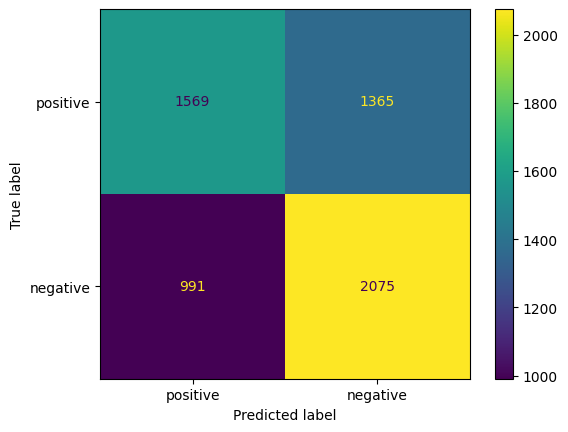

In [246]:
confusion_matr = confusion_matrix(test['sentiment'], y_pred, labels=['positive', 'negative'])

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matr, display_labels = ['positive', 'negative'])

cm_display.plot()
plt.show() 

In [242]:
accuracy_score(test['sentiment'], y_pred)

0.6073333333333333

In [243]:
precision_score(test['sentiment'], y_pred,average='macro')

0.6080441497093023

In [ ]:
# import json

# score = {}
# df_original = pd.read_csv('./data/IMDB Dataset.csv')
# for i in [5000,10000,15000,20000,25000,30000,40000,45000,50000]:
#     # Load the amazon review dataset
#     df = df_original.sample(i)

#     train, test = train_test_split(df,test_size=0.30, shuffle= True)

#     word_count_positive = calculate_word_counts(train[train['sentiment'] == 'positive']['review'])
#     word_count_negative = calculate_word_counts(train[train['sentiment'] == 'negative']['review'])

#     total_positive_words = sum(word_count_positive.values())
#     total_negative_words = sum(word_count_negative.values())

#     likelihood_positive = calculate_likelihood(word_count_positive, total_positive_words)
#     likelihood_negative = calculate_likelihood(word_count_negative, total_negative_words)

#     positive = calculate_log_prior('positive', train)
#     negative = calculate_log_prior('negative', train)

#     log_likelihood_positive = {word: math.log(prob) for word, prob in likelihood_positive.items()}
#     log_likelihood_negative = {word: math.log(prob) for word, prob in likelihood_negative.items()}


#     ###############################################
#     #PREDICT#
#     ###############################################


#     correct_predictions = 0
#     total_predictions = len(test)
#     y_pred = []

#     for index, row in test.iterrows():
#         predicted_sentiment, sentiment_scores = classify_review_with_scores(
#             row['review'], log_likelihood_positive, log_likelihood_negative,
#             positive, negative,
#         )
#         y_pred.append(predicted_sentiment)
        
        
#     ## METRICS
#     precision = precision_score(test['sentiment'], y_pred,average='macro')
#     accuracy = accuracy_score(test['sentiment'], y_pred)
    
#     score[i] = {"precision": precision, "accuracy": accuracy}
    
# with open('results.json', 'w') as f:
#     json.dump(score, f)